# 参考地址
[Kaggle竞赛-房价预测（House Prices）小结](https://zhuanlan.zhihu.com/p/39429689)

In [1]:
#导入相关依赖库
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#机器学习裤
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

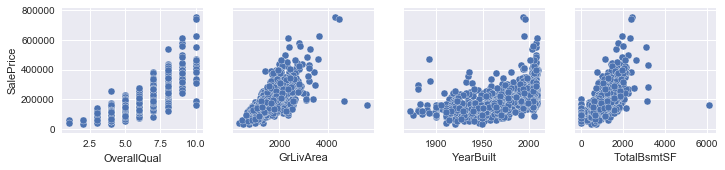

In [2]:
#读入训练数据，观察OverallQual、GrLivArea、YearBuilt、TotalBsmtSF四项数据对销售价格的影响
train_data=pd.read_csv('../data/train.csv')
figure=plt.figure()
sns.pairplot(x_vars=['OverallQual','GrLivArea','YearBuilt','TotalBsmtSF'],y_vars=['SalePrice'],data=train_data,dropna=True) #绘制多变量图
plt.show()

In [3]:
#将离群点清除
train_data.drop(train_data[(train_data['OverallQual']<5) & (train_data['SalePrice']>200000)].index,inplace=True)
train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<200000)].index,inplace=True)
train_data.drop(train_data[(train_data['YearBuilt']<1900) & (train_data['SalePrice']>400000)].index,inplace=True)
train_data.drop(train_data[(train_data['TotalBsmtSF']>6000) & (train_data['SalePrice']<200000)].index,inplace=True)
train_data.reset_index(drop=True, inplace=True)

In [4]:
#读入测试集数据，并与训练集合并在一起，一起进行数据清洗和特征工程
test_data=pd.read_csv('../data/test.csv')
my_data=pd.concat([train_data,test_data],axis=0)
my_data.reset_index(drop=True, inplace=True)
train_index=train_data.index
test_index=list(set(my_data.index).difference(set(train_data.index)))
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 

In [5]:
#查看缺失值
all_data=pd.concat([train_data,test_data])
count=all_data.isnull().sum().sort_values(ascending=False)
ratio=count/len(all_data)
nulldata=pd.concat([count,ratio],axis=1,keys=['count','ratio'])
print(nulldata)

               count     ratio
PoolQC          2906  0.996913
MiscFeature     2810  0.963979
Alley           2717  0.932075
Fence           2345  0.804460
SalePrice       1459  0.500515
FireplaceQu     1420  0.487136
LotFrontage      485  0.166381
GarageFinish     159  0.054545
GarageCond       159  0.054545
GarageQual       159  0.054545
GarageYrBlt      159  0.054545
GarageType       157  0.053859
BsmtCond          82  0.028130
BsmtExposure      82  0.028130
BsmtQual          81  0.027787
BsmtFinType2      80  0.027444
BsmtFinType1      79  0.027101
MasVnrType        24  0.008233
MasVnrArea        23  0.007890
MSZoning           4  0.001372
BsmtFullBath       2  0.000686
BsmtHalfBath       2  0.000686
Utilities          2  0.000686
Functional         2  0.000686
Electrical         1  0.000343
Exterior2nd        1  0.000343
KitchenQual        1  0.000343
Exterior1st        1  0.000343
GarageCars         1  0.000343
TotalBsmtSF        1  0.000343
...              ...       ...
Neighbor

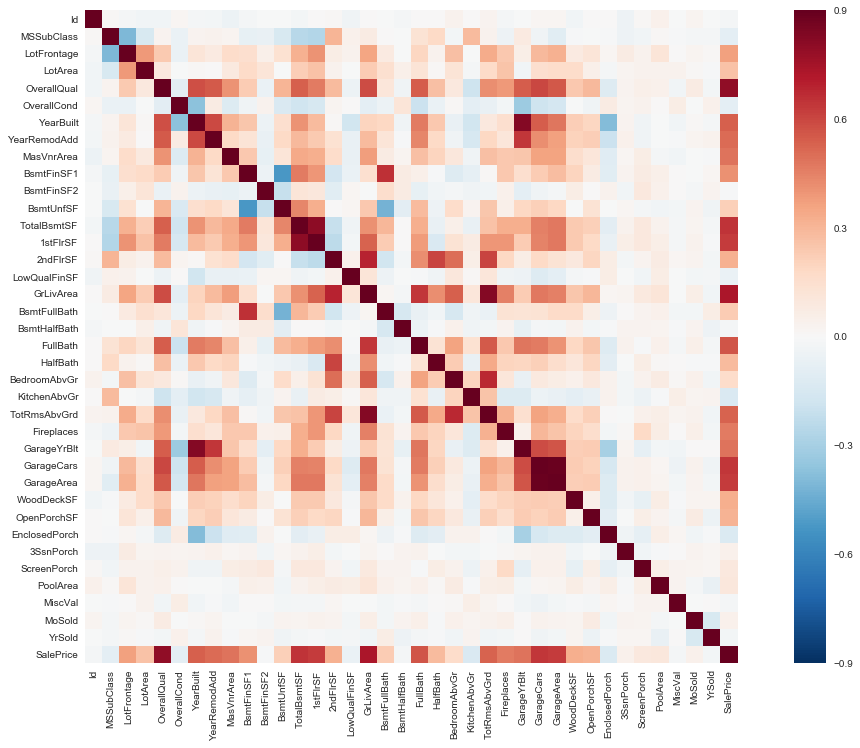

In [6]:
#观察变量之间的相关性
corrmat = train_data.corr()
plt.subplots(figsize=(20,12))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

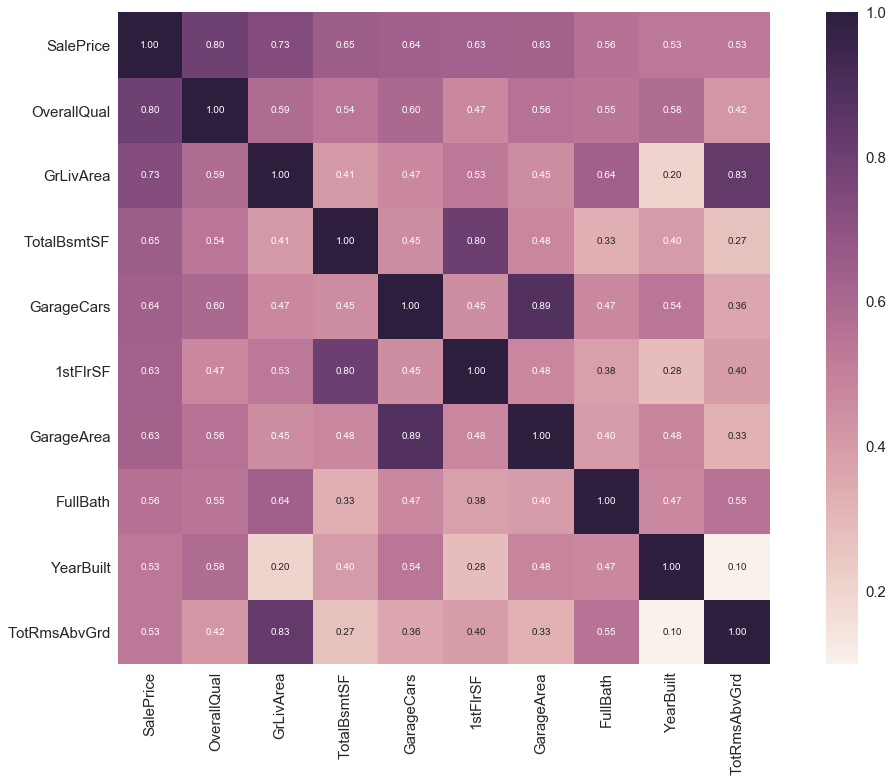

In [7]:
# 寻找K个最相关的特征信息
k = 10 # number of variables for heatmap
#print(train_corr.nlargest(k, 'SalePrice')['SalePrice'])
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index #nlargest查看最大的元素
#print(cols.values)
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale=1.5)
hm = plt.subplots(figsize=(20, 12))#调整画布大小
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [8]:
#填充缺失值,mode函数求的是众数
def fill_missings(res):

    res['Alley'] = res['Alley'].fillna('missing')
    res['PoolQC'] = res['PoolQC'].fillna(res['PoolQC'].mode()[0])
    res['MasVnrType'] = res['MasVnrType'].fillna('None')
    res['BsmtQual'] = res['BsmtQual'].fillna(res['BsmtQual'].mode()[0])
    res['BsmtCond'] = res['BsmtCond'].fillna(res['BsmtCond'].mode()[0])
    res['FireplaceQu'] = res['FireplaceQu'].fillna(res['FireplaceQu'].mode()[0])
    res['GarageType'] = res['GarageType'].fillna('missing')
    res['GarageFinish'] = res['GarageFinish'].fillna(res['GarageFinish'].mode()[0])
    res['GarageQual'] = res['GarageQual'].fillna(res['GarageQual'].mode()[0])
    res['GarageCond'] = res['GarageCond'].fillna('missing')
    res['Fence'] = res['Fence'].fillna('missing')
    res['Street'] = res['Street'].fillna('missing')
    res['LotShape'] = res['LotShape'].fillna('missing')
    res['LandContour'] = res['LandContour'].fillna('missing')
    res['BsmtExposure'] = res['BsmtExposure'].fillna(res['BsmtExposure'].mode()[0])
    res['BsmtFinType1'] = res['BsmtFinType1'].fillna('missing')
    res['BsmtFinType2'] = res['BsmtFinType2'].fillna('missing')
    res['CentralAir'] = res['CentralAir'].fillna('missing')
    res['Electrical'] = res['Electrical'].fillna(res['Electrical'].mode()[0])
    res['MiscFeature'] = res['MiscFeature'].fillna('missing')
    res['MSZoning'] = res['MSZoning'].fillna(res['MSZoning'].mode()[0])    
    res['Utilities'] = res['Utilities'].fillna('missing')
    res['Exterior1st'] = res['Exterior1st'].fillna(res['Exterior1st'].mode()[0])
    res['Exterior2nd'] = res['Exterior2nd'].fillna(res['Exterior2nd'].mode()[0])    
    res['KitchenQual'] = res['KitchenQual'].fillna(res['KitchenQual'].mode()[0])
    res["Functional"] = res["Functional"].fillna("Typ")
    res['SaleType'] = res['SaleType'].fillna(res['SaleType'].mode()[0])
    # res['SaleCondition'] = res['SaleCondition'].fillna('missing')
    #数值型变量的空值先用0值替换
    flist = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                     'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                     'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                     'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                     'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','GarageYrBlt']
    for fl in flist:
        res[fl] = res[fl].fillna(0)
    #0值替换   
    res['TotalBsmtSF'] = res['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    res['2ndFlrSF'] = res['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
    res['GarageArea'] = res['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    res['GarageCars'] = res['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
    res['LotFrontage'] = res['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
    res['MasVnrArea'] = res['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
    res['BsmtFinSF1'] = res['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)    
    return res
mydata=fill_missings(my_data)

In [9]:
#检查是否还有缺失值
count=mydata.isnull().sum().sort_values(ascending=False)
ratio=count/len(mydata)
nulldata=pd.concat([count,ratio],axis=1,keys=['count','ratio'])
print(nulldata)

               count     ratio
SalePrice       1459  0.500515
FullBath           0  0.000000
ExterCond          0  0.000000
ExterQual          0  0.000000
Exterior1st        0  0.000000
Exterior2nd        0  0.000000
Fence              0  0.000000
FireplaceQu        0  0.000000
Fireplaces         0  0.000000
Foundation         0  0.000000
YrSold             0  0.000000
Electrical         0  0.000000
Functional         0  0.000000
GarageArea         0  0.000000
GarageCars         0  0.000000
GarageCond         0  0.000000
GarageFinish       0  0.000000
GarageQual         0  0.000000
GarageType         0  0.000000
GarageYrBlt        0  0.000000
EnclosedPorch      0  0.000000
Condition2         0  0.000000
HalfBath           0  0.000000
BsmtFinSF1         0  0.000000
2ndFlrSF           0  0.000000
3SsnPorch          0  0.000000
Alley              0  0.000000
BedroomAbvGr       0  0.000000
BldgType           0  0.000000
BsmtCond           0  0.000000
...              ...       ...
SaleType

In [10]:
#数据类型转换
mydata['MSSubClass'] = mydata['MSSubClass'].apply(str)
mydata['YrSold'] = mydata['YrSold'].astype(str)
mydata['MoSold'] = mydata['MoSold'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

In [11]:
#顺序特征编码
mydata['TotalSF'] = mydata['TotalBsmtSF'] + mydata['1stFlrSF'] + mydata['2ndFlrSF']
def QualToInt(x):
    if(x=='Ex'):
        r = 0
    elif(x=='Gd'):
        r = 1
    elif(x=='TA'):
        r = 2
    elif(x=='Fa'):
        r = 3
    elif(x=='missing'):
        r = 4
    else:
        r = 5
    return r
mydata['ExterQual'] = mydata['ExterQual'].apply(QualToInt)
mydata['ExterCond'] = mydata['ExterCond'].apply(QualToInt)
mydata['KitchenQual'] = mydata['KitchenQual'].apply(QualToInt)
mydata['HeatingQC'] = mydata['HeatingQC'].apply(QualToInt)
mydata['BsmtQual'] = mydata['BsmtQual'].apply(QualToInt)
mydata['BsmtCond'] = mydata['BsmtCond'].apply(QualToInt)
mydata['FireplaceQu'] = mydata['FireplaceQu'].apply(QualToInt)
mydata['GarageQual'] = mydata['GarageQual'].apply(QualToInt)
mydata['PoolQC'] = mydata['PoolQC'].apply(QualToInt)

In [12]:
#组合特征，添加新的特征
#将totalBsmtSF/1stFlrSF/2ndFlrSF变量组合新的特征
mydata['TotalSF'] = mydata['TotalBsmtSF'] + mydata['1stFlrSF'] + mydata['2ndFlrSF']

#房屋是否有别的区域空间
mydata['HasWoodDeck'] = (mydata['WoodDeckSF'] == 0) * 1
mydata['HasOpenPorch'] = (mydata['OpenPorchSF'] == 0) * 1
mydata['HasEnclosedPorch'] = (mydata['EnclosedPorch'] == 0) * 1
mydata['Has3SsnPorch'] = (mydata['3SsnPorch'] == 0) * 1
mydata['HasScreenPorch'] = (mydata['ScreenPorch'] == 0) * 1

#房屋买卖间隔时间
mydata['YearsSinceRemodel'] = mydata['YrSold'].astype(int) - mydata['YearRemodAdd'].astype(int)

#房屋整体质量
mydata['Total_Home_Quality'] = mydata['OverallQual'] + mydata['OverallCond']

In [13]:
#数据转换
quantitative = [f for f in train_data.columns if train_data.dtypes[f] != 'object' and train_data.dtypes[f] != 'str']
quantitative.remove('SalePrice')
print(quantitative)
# f = pd.melt(train_data, value_vars=quantitative)
# g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
# g = g.map(sns.distplot, "value")
# plt.show()

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [14]:
# print(mydata[quantitative].skew().sort_values(ascending=False))
skewed_feats = mydata[quantitative].dropna().skew().sort_values(ascending=False)
# mydata['MSSubClass'].astype(float)
# skewed_feats = mydata[quantitative].apply(lambda x:skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew':skewed_feats})
skewness.head(20)

,Skew
MiscVal,21.943440
PoolArea,17.691647
LotArea,13.285898
LowQualFinSF,12.414102
3SsnPorch,11.373947
KitchenAbvGr,4.301059
BsmtFinSF2,4.144996
EnclosedPorch,4.002856
ScreenPorch,3.933649
BsmtHalfBath,3.930420


In [16]:
#对偏度skew大于0.15的定量进行log处理，用来提升质量
def addlogs(res, ls):
    m = res.shape[1]
    for l in ls:
        a=res[l]
        res = res.assign(newcol=pd.Series(np.log(1.01+a.astype(float))).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res
loglist=skewness[abs(skewness)>0.15].index.tolist()
mydata = addlogs(mydata, loglist)

In [17]:
#去除之前的顺序编码变量
qualitative = [f for f in train_data.columns if train_data.dtypes[f] == 'object'or train_data.dtypes[f] == 'str']
oridnals=['BsmtFinType1','MasVnrType','Foundation','HouseStyle','Functional','BsmtExposure','GarageFinish','PavedDrive','Street',
                   'ExterQual', 'PavedDrive','ExterQua','ExterCond','KitchenQual','HeatingQC','BsmtQual','FireplaceQu','GarageQual','PoolQC']
qualitative=list(set(qualitative).difference(set(oridnals)))

In [38]:
#将定型编码变量进行读入编码，并将顺序编码数据合并为一个数据集
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
def getdummies(res, ls):
    def encode(encode_df):
        encode_df = np.array(encode_df)
        enc = OneHotEncoder()
        le = LabelEncoder()
        le.fit(encode_df)
        res1 = le.transform(encode_df).reshape(-1, 1)
        enc.fit(res1)
        return pd.DataFrame(enc.transform(res1).toarray()), le, enc
    
    decoder = []
    outres = pd.DataFrame({'A' : []})

    for l in ls:
        cat, le, enc = encode(res[l])
        cat.columns = [l+str(x) for x in cat.columns]
        outres.reset_index(drop=True, inplace=True)
        outres = pd.concat([outres, cat], axis = 1)
        decoder.append([le,enc])     
    return (outres, decoder)
catpredlist=qualitative


res = getdummies(mydata[catpredlist],catpredlist)
df = res[0]
decoder = res[1]
floatAndordinal=list(set(mydata.columns.values).difference(set(qualitative)))
mydata.columns.values
print(df.shape)
df = pd.concat([df,mydata[floatAndordinal]],axis=1)
df.drop(['SalePrice'],axis=1,inplace=True)

df.drop(['BsmtFinType1'],axis=1,inplace=True)
df.drop(['Functional'],axis=1,inplace=True)
# df.drop(['AP'],axis=1,inplace=True)

df.info()
df.head()
# print(df["BsmtFinType1"])
# print(df["Functional"])
# print(df["CentralAir"])

(2915, 181)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915 entries, 0 to 2914
Columns: 278 entries, A to GarageYrBlt
dtypes: float64(231), int32(6), int64(31), object(10)
memory usage: 6.1+ MB


KeyError: 'CentralAir'

In [34]:
#数据降维
from sklearn.decomposition import PCA
pca = PCA(n_components=295)
pca.fit(df)
df = pca.transform(df)
df = pd.DataFrame(df)

ValueError: could not convert string to float: 'Y'

In [ ]:
#数据集重新拆分为测试集和训练集
df_train=df.iloc[train_index]
df_score=df.iloc[test_index]
my_traindata=mydata.iloc[train_index]
X=np.array(df_train)
X=np.delete(X,0,1)
y=np.log(1+np.array(my_traindata['SalePrice']))
X.shape

In [ ]:
#建模
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold,GridSearchCV
nF = 20
kf = KFold(n_splits=nF, random_state=241, shuffle=True)

test_errors_l2 = []
train_errors_l2 = []
test_errors_l1 = []
train_errors_l1 = []
test_errors_GBR = []
train_errors_GBR = []
test_errors_ENet = []
test_errors_LGB = []
test_errors_stack = []
test_errors_ens = []
train_errors_ens = []

models = []

pred_all = []

ifold = 1

for train_index, test_index in kf.split(X):
    print('fold: ',ifold)
    ifold = ifold + 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # ridge
    l2Regr = Ridge(alpha=9.0, fit_intercept = True)
    l2Regr.fit(X_train, y_train)
    pred_train_l2 = l2Regr.predict(X_train)
    pred_test_l2 = l2Regr.predict(X_test)
    
    # lasso
    l1Regr = make_pipeline(RobustScaler(), Lasso(alpha = 0.0003, random_state=1, max_iter=50000))
    l1Regr.fit(X_train, y_train)
    pred_train_l1 = l1Regr.predict(X_train)
    pred_test_l1 = l1Regr.predict(X_test)
    
    # GBR      
    myGBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.02,
                                      max_depth=4, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=50,
                                      loss='huber', random_state = 5) 
    
    myGBR.fit(X_train,y_train)
    pred_train_GBR = myGBR.predict(X_train)

    pred_test_GBR = myGBR.predict(X_test)
    
    # ENet
    ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=4.0, l1_ratio=0.005, random_state=3))
    ENet.fit(X_train, y_train)
    pred_train_ENet = ENet.predict(X_train)
    pred_test_ENet = ENet.predict(X_test) 
    
    # LGB
    myLGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=600,
                              max_bin = 50, bagging_fraction = 0.6,
                              bagging_freq = 5, feature_fraction = 0.25,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)
    myLGB.fit(X_train, y_train)
    pred_train_LGB = myLGB.predict(X_train)
    pred_test_LGB = myLGB.predict(X_test)      
    
    # Stacking
    stackedset = pd.DataFrame({'A' : []})
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_l2)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_l1)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_GBR)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_ENet)],axis=1)
    stackedset = pd.concat([stackedset,pd.DataFrame(pred_test_LGB)],axis=1)
    #prod = (pred_test_l2*pred_test_l1*pred_test_GBR*pred_test_ENet*pred_test_LGB) ** (1.0/5.0)
    #stackedset = pd.concat([stackedset,pd.DataFrame(prod)],axis=1)
    Xstack = np.array(stackedset)
    Xstack = np.delete(Xstack, 0, axis=1)
    l1_staked = Lasso(alpha = 0.0001,fit_intercept = True)
    l1_staked.fit(Xstack, y_test)
    pred_test_stack = l1_staked.predict(Xstack)
    models.append([l2Regr,l1Regr,myGBR,ENet,myLGB,l1_staked])

In [ ]:
X_score = np.array(df_score)
X_score =np.delete(X_score,0,1)
M=X_score.shape[0]
scores_fin = 1+np.zeros(M)
for m in models:
    ger=m[0]
    las=m[1]
    gbr=m[2]
    Enet=m[3]
    lgb=m[4]
    las2=m[5]
    ger_predict=ger.predict(X_score)
    las_predict=las.predict(X_score)
    gbr_predict=gbr.predict(X_score)
    Enet_predict=Enet.predict(X_score)
    lgb_predict=lgb.predict(X_score)
    X_stack=pd.DataFrame({"A":[]})
    X_stack=pd.concat([X_stack,pd.DataFrame(ger_predict),pd.DataFrame(las_predict),pd.DataFrame(gbr_predict),pd.DataFrame(Enet_predict),pd.DataFrame(lgb_predict)],axis=1)
    X_stack=np.array(X_stack)
    X_stack=np.delete(X_stack,0,1)
    scores_fin=scores_fin*(las2.predict(X_stack))
scores_fin = scores_fin ** (1/nF)